# Metrics and Plots for the trained models

In [28]:
MAIN_DUMP='../../dump/'
import os,sys
from joblib import Parallel, delayed,dump,load

sys.path.append(os.path.abspath('../../src/ml'))
from load_matrix import load_df
from model_trainer import MLModel
from utils import load_models

import pandas as pd

from evaluator import Evaluator
from collector import ResultsCollector
from visualizer import DashboardVisualizer


## v2.10

In [29]:
current_version='v2.10'
standard_models=load_models(MAIN_DUMP,version=current_version,normalization='standard')
robust_models=load_models(MAIN_DUMP,version=current_version,normalization='robust')
none_models =load_models(MAIN_DUMP,version=current_version,normalization='none')
log1p_models=load_models(MAIN_DUMP,version=current_version,normalization='log1p')
minmax_models=load_models(MAIN_DUMP,version=current_version,normalization='minmax')

In [30]:
collector = ResultsCollector()
metrics_list = []
metrics_list=[]
for norm in ['none','robust','standard','log1p','minmax']:
        current_dict=eval(f"{norm}_models")
        for model_name, ml_model in current_dict.items():
                print(f'-- Evaluating model: {model_name} {current_version} {norm} --')
                y_test, y_pred, y_proba = ml_model.y_test, ml_model.y_pred, ml_model.y_proba
                metrics = Evaluator(y_test, y_pred, y_proba).compute_metrics()
                metrics_list.append({
                        "model": ml_model.model_type,
                        "input": ml_model.dataset_name,
                        "normalization": norm,  
                        "version": current_version,
                        **metrics
                })

                collector.add(ml_model.model_type, ml_model.dataset_name, y_test, y_pred, y_proba)
results=pd.DataFrame(metrics_list)

# -- gex not related to version
results.loc[results['input']=='gene_expression', 'version'] = ''

-- Evaluating model: pytorch_mlp_Complex_protein_embeddings_gridsearch_model.joblib v2.10 none --
-- Evaluating model: pytorch_mlp_Complex_sample_embeddings_gridsearch_model.joblib v2.10 none --
-- Evaluating model: pytorch_mlp_concatenated_protein_embeddings_gridsearch_model.joblib v2.10 none --
-- Evaluating model: pytorch_mlp_concatenated_sample_embeddings_gridsearch_model.joblib v2.10 none --
-- Evaluating model: pytorch_mlp_gene_expression_gridsearch_model.joblib v2.10 none --
-- Evaluating model: pytorch_mlp_RGCN_protein_embeddings_gridsearch_model.joblib v2.10 none --
-- Evaluating model: pytorch_mlp_RGCN_sample_embeddings_gridsearch_model.joblib v2.10 none --
-- Evaluating model: random_forest_Complex_protein_embeddings_gridsearch_model.joblib v2.10 none --
-- Evaluating model: random_forest_Complex_sample_embeddings_gridsearch_model.joblib v2.10 none --
-- Evaluating model: random_forest_concatenated_protein_embeddings_gridsearch_model.joblib v2.10 none --
-- Evaluating model:

In [31]:
results[results['input']=='gene_expression'] # -- checking version

,model,input,normalization,version,balanced_accuracy,precision,recall,f1,mcc,auroc,auprc,brier
4,pytorch_mlp,gene_expression,none,,0.500000,0.787879,1.0,0.881356,0.000000,0.500000,0.787879,0.186877
11,random_forest,gene_expression,none,,0.785714,0.896552,1.0,0.945455,0.715762,0.994505,0.998575,0.077027
18,sklearn_mlp,gene_expression,none,,0.500000,0.787879,1.0,0.881356,0.000000,0.587912,0.822746,0.167189
25,svm,gene_expression,none,,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.007722
32,xgboost,gene_expression,none,,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.030040


In [32]:
results_10=results

In [33]:
results.loc[results['model']=='svm']

,model,input,normalization,version,balanced_accuracy,precision,recall,f1,mcc,auroc,auprc,brier
21,svm,Complex_protein_embeddings,none,v2.10,0.909341,0.961538,0.961538,0.961538,0.818681,0.016484,0.599918,0.174254
22,svm,Complex_sample_embeddings,none,v2.10,0.500000,0.787879,1.000000,0.881356,0.000000,0.692308,0.863585,0.164562
23,svm,concatenated_protein_embeddings,none,v2.10,0.500000,0.787879,1.000000,0.881356,0.000000,0.494505,0.831526,0.167219
24,svm,concatenated_sample_embeddings,none,v2.10,0.500000,0.787879,1.000000,0.881356,0.000000,0.774725,0.939154,0.162733
25,svm,gene_expression,none,,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.007722
26,svm,RGCN_protein_embeddings,none,v2.10,0.500000,0.787879,1.000000,0.881356,0.000000,0.494505,0.831526,0.167306
27,svm,RGCN_sample_embeddings,none,v2.10,0.500000,0.787879,1.000000,0.881356,0.000000,0.763736,0.934186,0.162838
44,svm,Complex_protein_embeddings,robust,v2.10,0.785714,0.896552,1.000000,0.945455,0.715762,0.865385,0.960925,0.102933
45,svm,concatenated_protein_embeddings,robust,v2.10,0.500000,0.787879,1.000000,0.881356,0.000000,0.384615,0.750626,0.168833
46,svm,RGCN_protein_embeddings,robust,v2.10,0.500000,0.787879,1.000000,0.881356,0.000000,0.384615,0.750626,0.168458


## v2.11

In [35]:
current_version='v2.11'
standard_models=load_models(MAIN_DUMP,version=current_version,normalization='standard')
robust_models=load_models(MAIN_DUMP,version=current_version,normalization='robust')
none_models =load_models(MAIN_DUMP,version=current_version,normalization='none')
log1p_models=load_models(MAIN_DUMP,version=current_version,normalization='log1p')
minmax_models=load_models(MAIN_DUMP,version=current_version,normalization='minmax')

collector = ResultsCollector()
metrics_list = []
metrics_list=[]
for norm in ['none','robust','standard','log1p','minmax']:
        current_dict=eval(f"{norm}_models")
        for model_name, ml_model in current_dict.items():
                print(f'-- Evaluating model: {model_name} {current_version} {norm} --')
                y_test, y_pred, y_proba = ml_model.y_test, ml_model.y_pred, ml_model.y_proba
                metrics = Evaluator(y_test, y_pred, y_proba).compute_metrics()
                metrics_list.append({
                        "model": ml_model.model_type,
                        "input": ml_model.dataset_name,
                        "normalization": norm,  
                        "version": current_version,
                        **metrics
                })

                collector.add(ml_model.model_type, ml_model.dataset_name, y_test, y_pred, y_proba)
results=pd.DataFrame(metrics_list)
results.loc[results['input']=='gene_expression', 'version'] = ''

-- Evaluating model: pytorch_mlp_Complex_protein_embeddings_gridsearch_model.joblib v2.11 none --
-- Evaluating model: pytorch_mlp_Complex_sample_embeddings_gridsearch_model.joblib v2.11 none --
-- Evaluating model: pytorch_mlp_concatenated_protein_embeddings_gridsearch_model.joblib v2.11 none --
-- Evaluating model: pytorch_mlp_concatenated_sample_embeddings_gridsearch_model.joblib v2.11 none --
-- Evaluating model: pytorch_mlp_gene_expression_gridsearch_model.joblib v2.11 none --
-- Evaluating model: pytorch_mlp_RGCN_protein_embeddings_gridsearch_model.joblib v2.11 none --
-- Evaluating model: pytorch_mlp_RGCN_sample_embeddings_gridsearch_model.joblib v2.11 none --
-- Evaluating model: random_forest_Complex_protein_embeddings_gridsearch_model.joblib v2.11 none --
-- Evaluating model: random_forest_Complex_sample_embeddings_gridsearch_model.joblib v2.11 none --
-- Evaluating model: random_forest_concatenated_protein_embeddings_gridsearch_model.joblib v2.11 none --
-- Evaluating model:

In [36]:
results_11=results

### saving csv

In [38]:
results_10.to_csv('../../results/tables/scores_v2.10.csv',index=False)
results_11.to_csv('../../results/tables/scores_v2.11.csv',index=False)

all_results=pd.concat([results_10,results_11],axis=0)
all_results.to_csv('../../results/tables/scores_all.csv',index=False)

### analysis

In [39]:
from IPython.display import display
display(all_results)

,model,input,normalization,version,balanced_accuracy,precision,recall,f1,mcc,auroc,auprc,brier
0,pytorch_mlp,Complex_protein_embeddings,none,v2.10,0.500000,0.787879,1.000000,0.881356,0.000000,0.500000,0.787879,0.167604
1,pytorch_mlp,Complex_sample_embeddings,none,v2.10,0.500000,0.787879,1.000000,0.881356,0.000000,0.500000,0.787879,0.212121
2,pytorch_mlp,concatenated_protein_embeddings,none,v2.10,0.500000,0.000000,0.000000,0.000000,0.000000,0.500000,0.787879,0.787879
3,pytorch_mlp,concatenated_sample_embeddings,none,v2.10,0.500000,0.787879,1.000000,0.881356,0.000000,0.500000,0.787879,0.212121
4,pytorch_mlp,gene_expression,none,,0.500000,0.787879,1.000000,0.881356,0.000000,0.500000,0.787879,0.186877
...,...,...,...,...,...,...,...,...,...,...,...,...
90,svm,concatenated_protein_embeddings,minmax,v2.11,0.961538,1.000000,0.923077,0.960000,0.847319,0.967033,0.992023,0.057106
91,svm,RGCN_protein_embeddings,minmax,v2.11,0.961538,1.000000,0.923077,0.960000,0.847319,0.967033,0.992023,0.054701
92,xgboost,Complex_protein_embeddings,minmax,v2.11,0.961538,1.000000,0.923077,0.960000,0.847319,1.000000,1.000000,0.028402
93,xgboost,concatenated_protein_embeddings,minmax,v2.11,0.961538,1.000000,0.923077,0.960000,0.847319,0.994505,0.998575,0.040890


In [40]:
datasets=['Complex_protein_embeddings','RGCN_protein_embeddings','concatenated_protein_embeddings']
temp_df=all_results[all_results['input'].isin(datasets)].sort_values(by=['input','model','version','normalization'])

In [41]:
df=temp_df
df['normalization'].unique()

array(['log1p', 'minmax', 'none', 'robust', 'standard'], dtype=object)

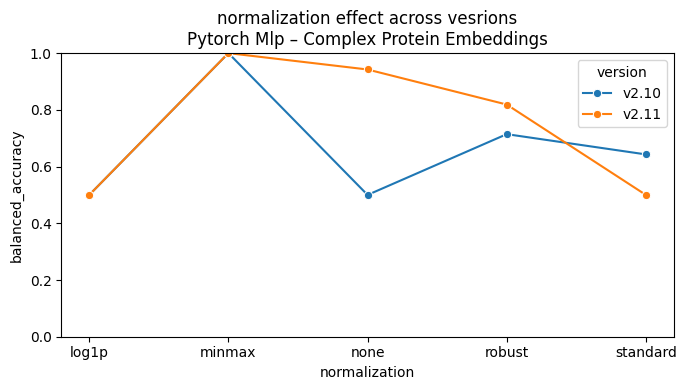

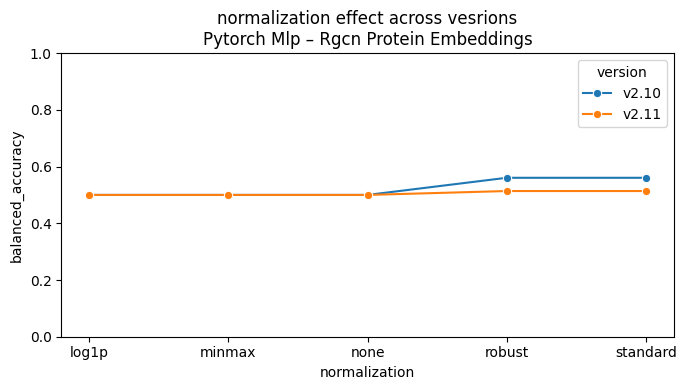

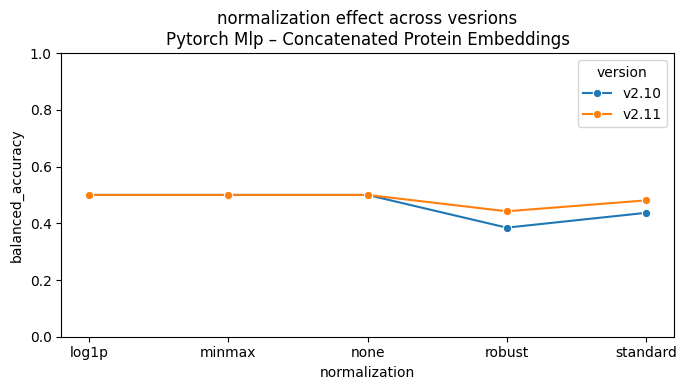

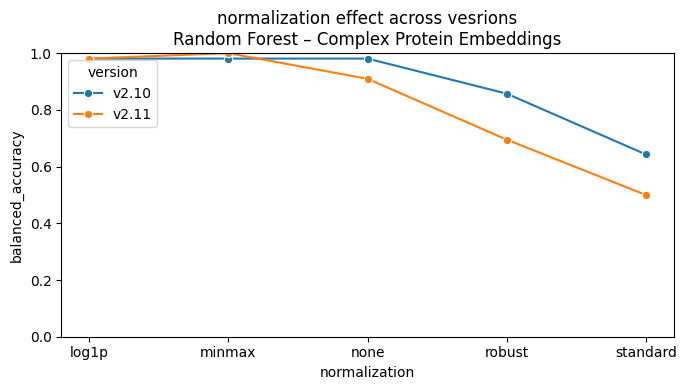

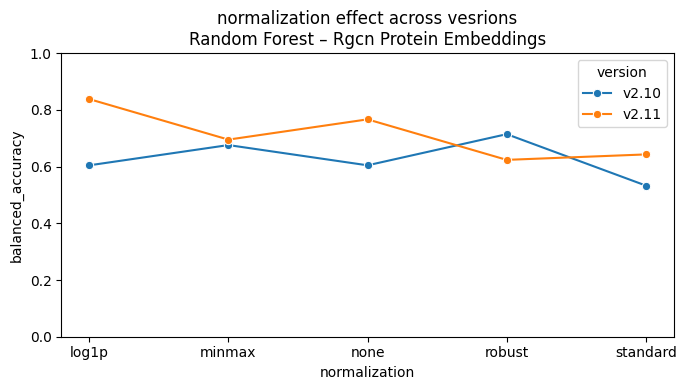

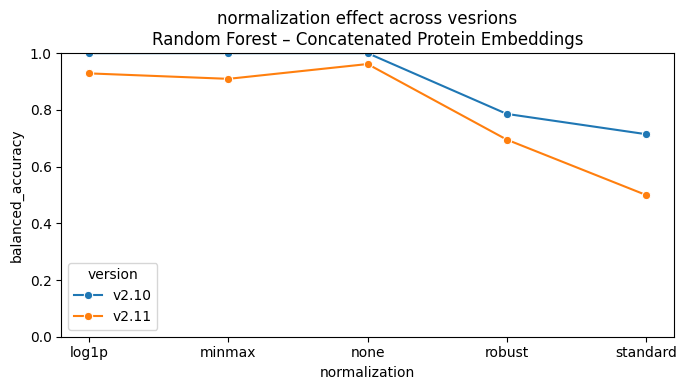

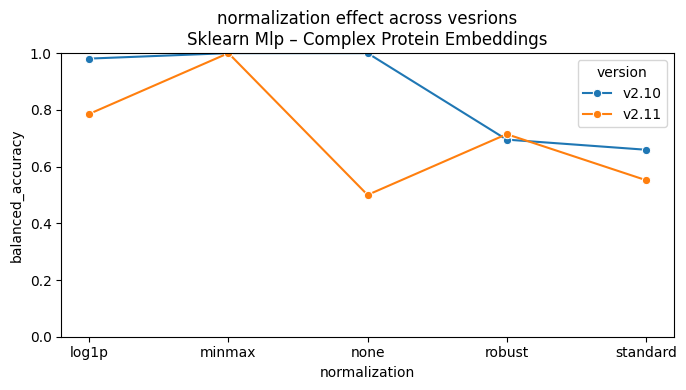

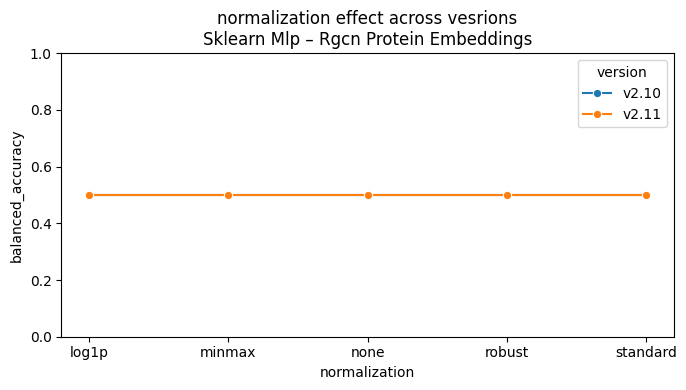

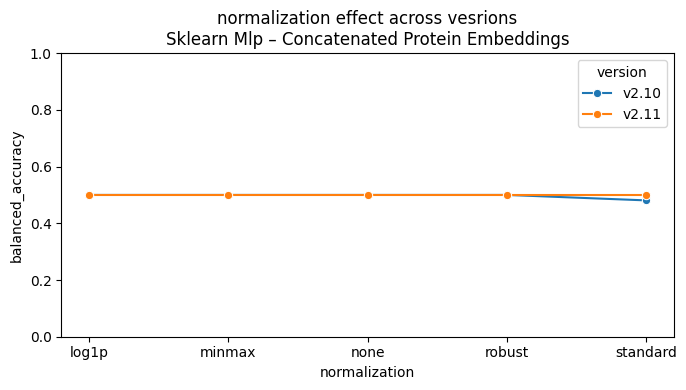

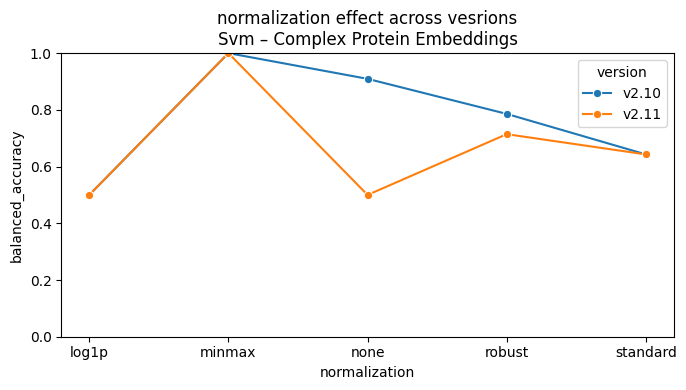

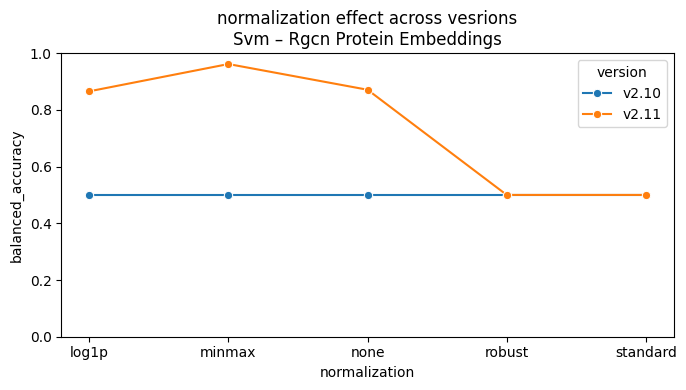

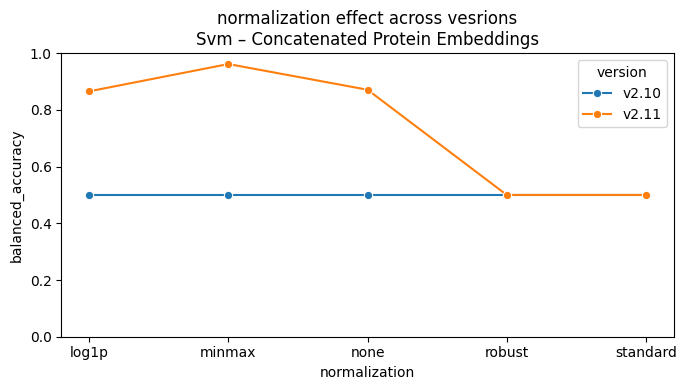

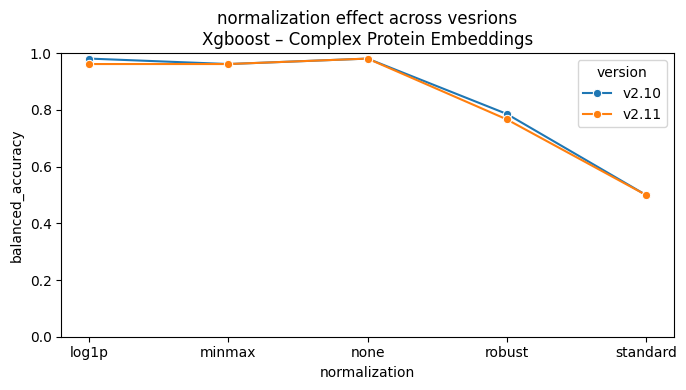

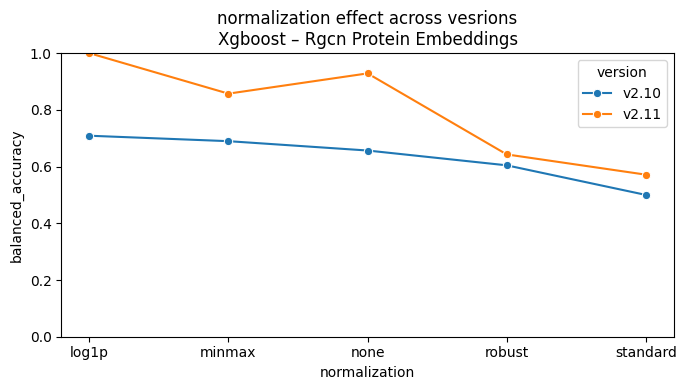

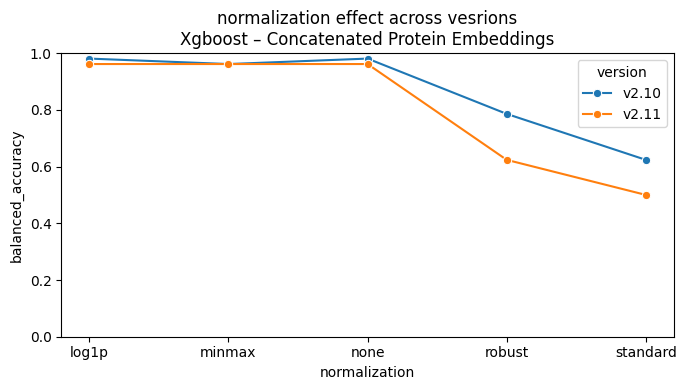

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

metric='balanced_accuracy'

for model in df['model'].unique():
    for dataset in df['input'].unique():
        subset = df[
            (df["model"] == model) &
            (df["input"] == dataset)
        ]

        plt.figure(figsize=(7,4))
        sns.lineplot(
            data=subset,
            x="normalization",
            y=metric,
            hue="version",
            marker="o"
        )

        plt.ylabel(metric)
        plt.xlabel("normalization")
        plt.title(f"normalization effect across vesrions\n{model.replace('_',' ').title()} – {dataset.replace('_',' ').title()}")
        plt.ylim(0, 1)

        plt.tight_layout()
        plt.show()

### Viz

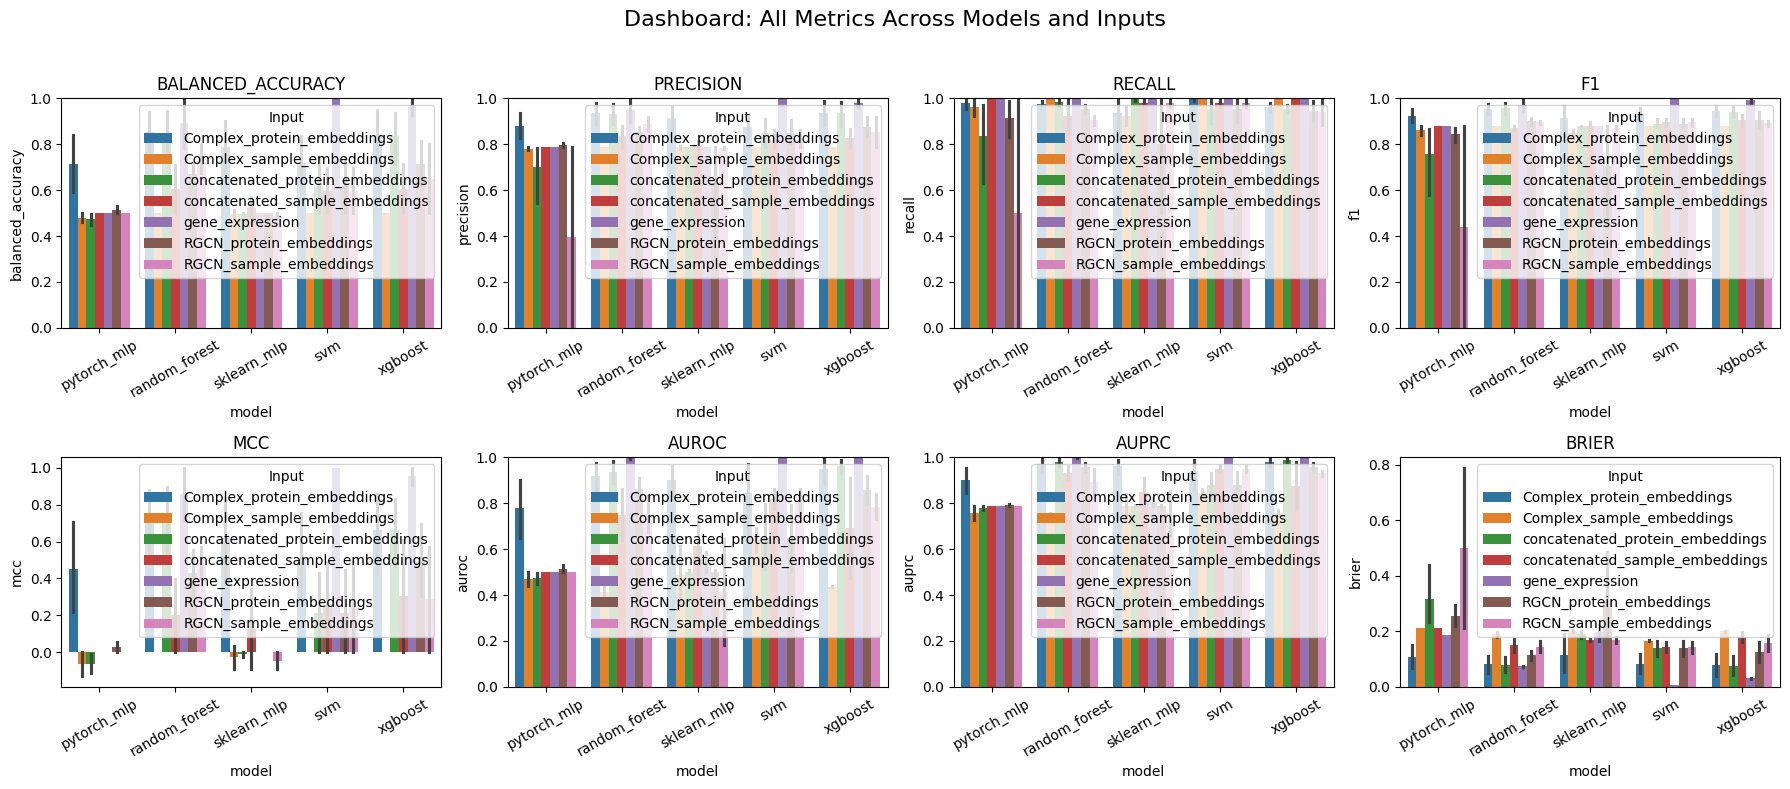

In [44]:
collector = ResultsCollector()
dashboard = DashboardVisualizer(all_results, collector)
dashboard.plot_metric_grid()


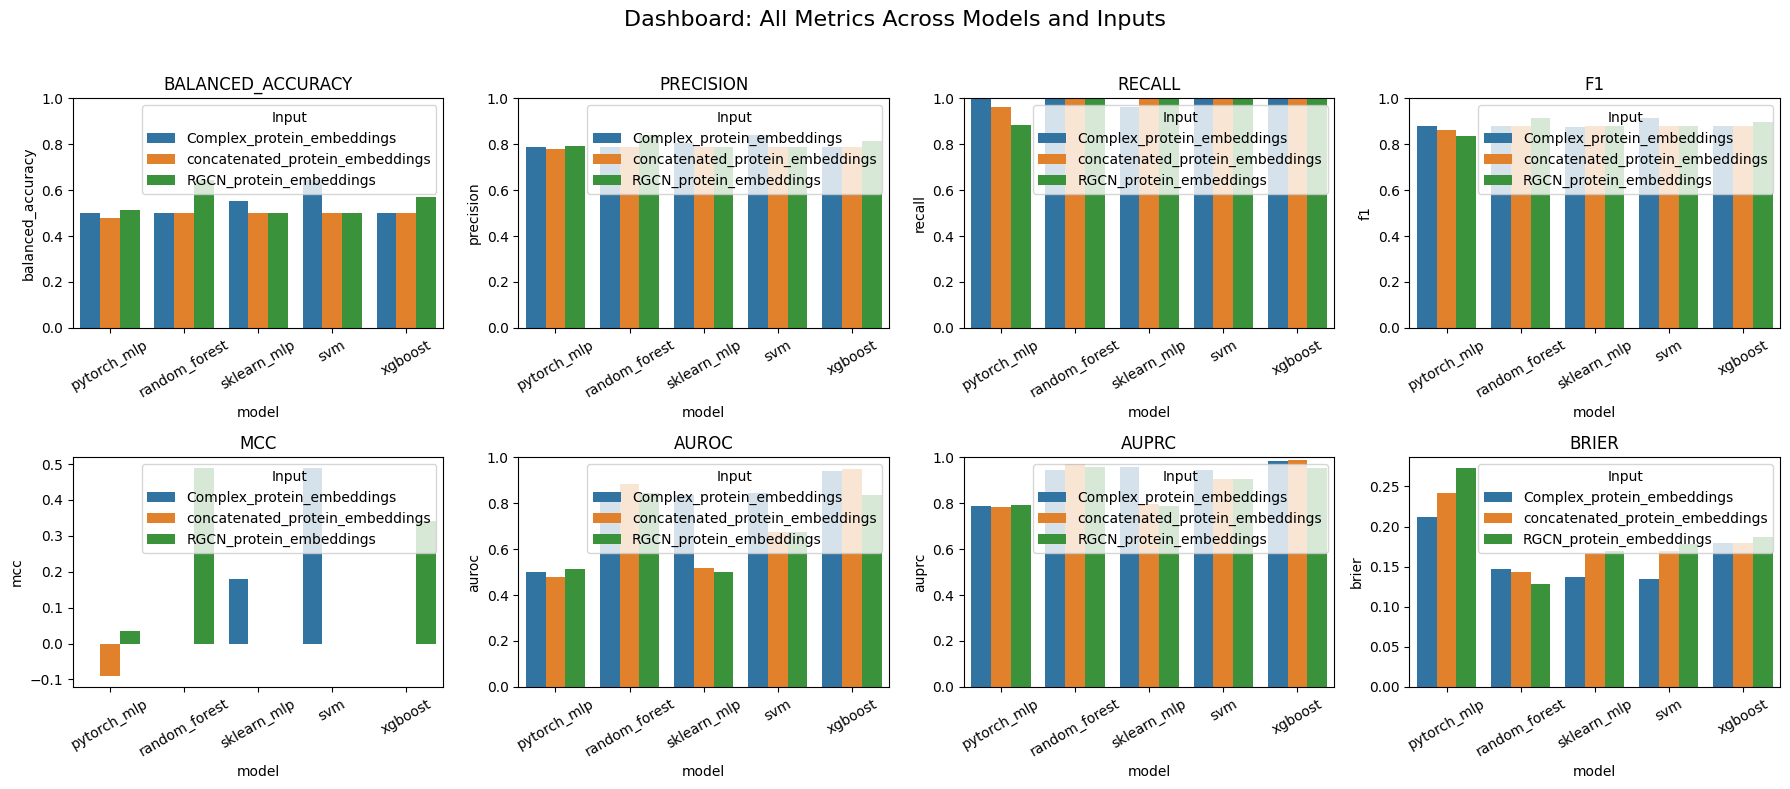

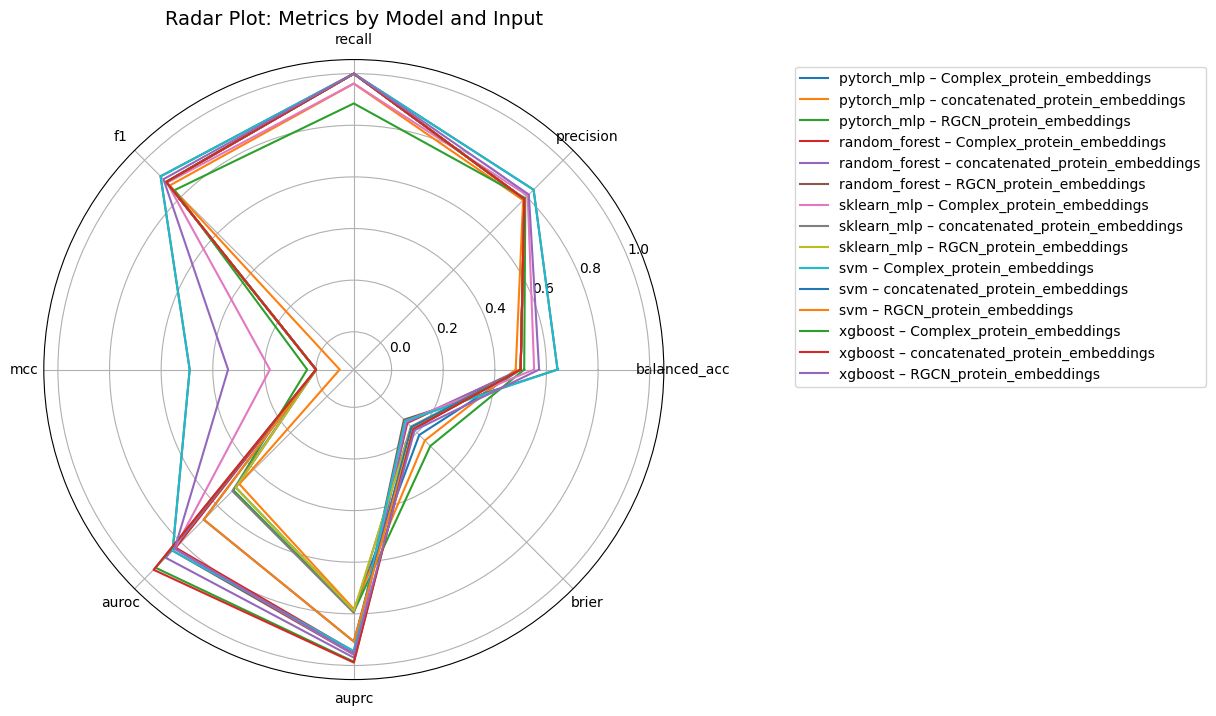

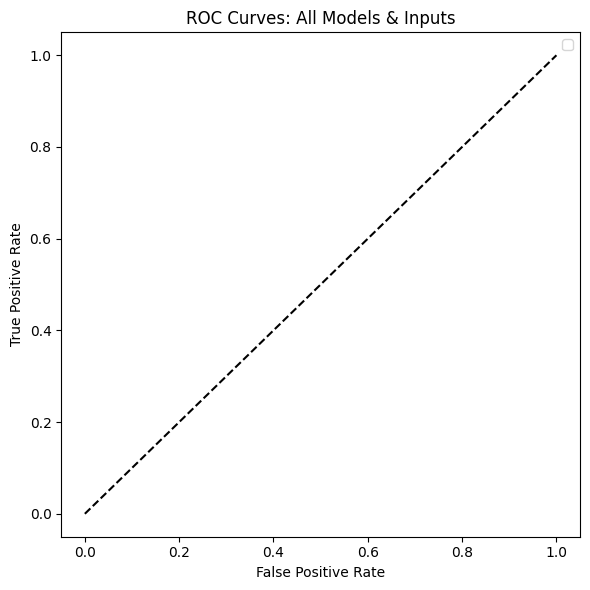

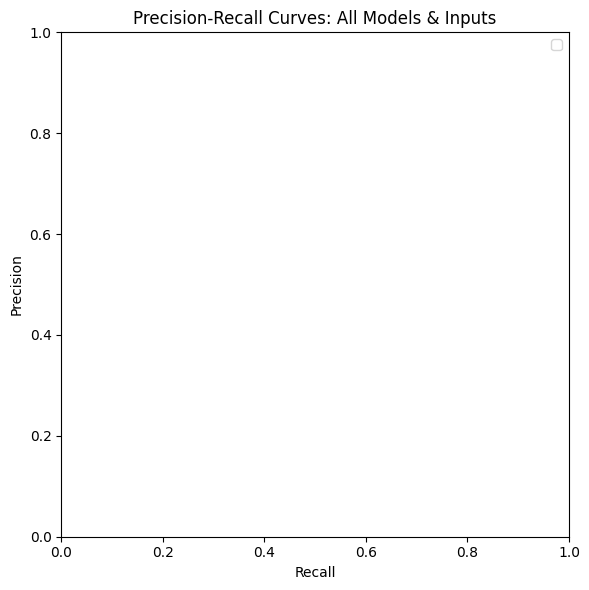

In [53]:
unify_norm=results.loc[results['normalization']=='standard']
dashboard = DashboardVisualizer(unify_norm, collector)
dashboard.plot_metric_grid()
dashboard.plot_radar()
dashboard.plot_roc_curves()
dashboard.plot_pr_curves()